# RecSys Challenge 2022 Research Notebook

## Introduction

Authors : 
- Henri Jamet <henri.jamet@epita.fr>
- Corentin Duchene <corentin.duchene@epita.fr>
- Adrien Merat <adrien.merat@epita.fr>
- Erwan Goudard <erwan.goudard@epita.fr>

Projet :
- http://www.recsyschallenge.com/2022/index.html#about
- http://www.recsyschallenge.com/2022/dataset.html

## Data Exploration

The data should first be downloaded and unpacked into the data folder at the root of this project. So we should have :

```shell
data
├── README.txt
├── README_win.txt
├── candidate_items.csv
├── item_features.csv
├── test_final_sessions.csv
├── test_leaderboard_sessions.csv
├── train_purchases.csv
└── train_sessions.csv
```


**Let's load our data**

In [1]:
import pandas as pd
import os

PATH_DATA = os.path.join("..", "data")

train_session_df = pd.read_csv(os.path.join(PATH_DATA, "train_sessions.csv"))
train_purchase_df = pd.read_csv(os.path.join(PATH_DATA, "train_purchases.csv"))
candidate_items_df = pd.read_csv(os.path.join(PATH_DATA, "candidate_items.csv"))
item_features_df = pd.read_csv(os.path.join(PATH_DATA, "item_features.csv"))
test_final_sessions_df = pd.read_csv(os.path.join(PATH_DATA, "test_final_sessions.csv"))
test_leaderboard_sessions_df = pd.read_csv(os.path.join(PATH_DATA, "test_leaderboard_sessions.csv"))

dict = {"train_session_df" : train_session_df, "train_purchase_df" : train_purchase_df, "candidate_items_df" : candidate_items_df, "item_features_df" : item_features_df, "test_final_sessions_df" : test_final_sessions_df, "test_leaderboard_sessions_df" : test_leaderboard_sessions_df}
for key in dict:
    print(key)
    print(dict[key].head(1), end="\n\n")

train_session_df
   session_id  item_id                     date
0           3     9655  2020-12-18 21:25:00.373

train_purchase_df
   session_id  item_id                     date
0           3    15085  2020-12-18 21:26:47.986

candidate_items_df
   item_id
0        4

item_features_df
   item_id  feature_category_id  feature_value_id
0        2                   56               365

test_final_sessions_df
   session_id  item_id                     date
0          61    27088  2021-06-01 08:12:39.664

test_leaderboard_sessions_df
   session_id  item_id                     date
0          26    19185  2021-06-16 09:53:54.158



*How many different items does exist?*

In [2]:
distinct_item_number = len(item_features_df.item_id.unique())
print("Unique item number :", distinct_item_number)
print("Item id are unique : ", item_features_df.item_id.nunique() == len(item_features_df.item_id.unique()))

Unique item number : 23691
Item id are unique :  True


*How many different sessions does exist?*

In [3]:
distinct_session_number = len(pd.concat([train_session_df.session_id, train_purchase_df.session_id]).unique())
print("Unique user number :", distinct_session_number)

Unique user number : 1000000


*How many candidate items exist?*

In [4]:
print("it exists", len(candidate_items_df.item_id.unique()), "different candidate items")

it exists 4990 different candidate items


*Does session always look an item before buying it?*

In [5]:
import numpy as np

print("A user never look at one item before buying it.")
pd.merge(train_purchase_df, train_session_df, on=['session_id','item_id'], how='left', indicator='Exist')["Exist"].value_counts()

A user never look at one item before buying it.


left_only     1000000
right_only          0
both                0
Name: Exist, dtype: int64

*Can a session look at items without buying any?*

In [6]:
print("Every session bought exactly one item.")

pd.merge(train_purchase_df, train_session_df, on=['session_id'], how='left', indicator='Exist')["Exist"].value_counts()

Every session bought exactly one item.


both          4743820
left_only           0
right_only          0
Name: Exist, dtype: int64

*What is the average number of different items every user usually look?*

In [7]:
print("Average number of items seen by user :", train_session_df.groupby("session_id").count()["item_id"].mean())

Average number of items seen by user : 4.74382


*How many feature does exist?*

In [8]:
print("The number of different item features is :")
print(len(item_features_df["feature_category_id"].unique()))

The number of different item features is :
73


*How many items have the same feature?*

Text(0.5, 1.0, 'Number of different items features')

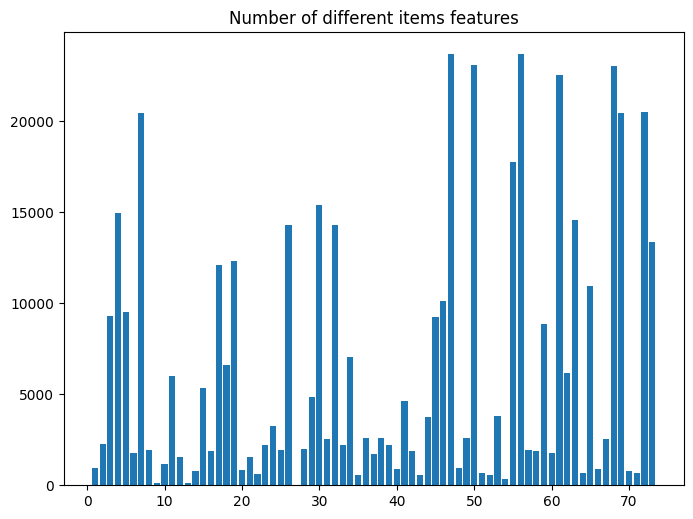

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
nbr = item_features_df.groupby("feature_category_id").count()["item_id"]
plt.bar(x=nbr.index, height=nbr.values)
plt.title("Number of different items features")

*How many feature en feature_score items have in commun generaly?*

This question is quite complex so we will first create a function giving this number for every items compared to one given because we will probably need this function soon or later anyway.

In [10]:

def get_item_similarity(item_features_df, item_id):
    """Get the similarity between the given item and all the others based on their features and feature values.

    Args:
        item_features_df (pd.DataFrame): The item features dataframe.
        item_id_1 (int): The id of the first item

    Returns:
        (pd.DataFrame): item | similar_feature_id | similar_value_id
    """
    item_df = item_features_df[item_features_df.item_id == item_id]
    if len(item_df) == 0:
        return None
    same_feature_id = item_features_df[item_features_df.feature_category_id.isin(item_df.feature_category_id)]
    same_value_id = same_feature_id[same_feature_id.feature_value_id.isin(item_df.feature_value_id)]
    return pd.concat([same_feature_id.groupby("item_id").count().feature_category_id.drop(index=item_id).rename("similar_feature_id"), same_value_id.groupby("item_id").count().feature_value_id.drop(index=item_id).rename("similar_value_id")], axis=1)

In [11]:
import numpy as np

ESTIMATION_SAMPLE_NUMBER = 1000

similar_feature_id = []
similar_value_id = []
for _, item_id in item_features_df.sample(ESTIMATION_SAMPLE_NUMBER).item_id.items():
    similarity = get_item_similarity(item_features_df, item_id) / distinct_item_number
    if similarity is None:
        continue
    similarity = similarity.sum()
    similar_feature_id.append(similarity.similar_feature_id)
    similar_value_id.append(similarity.similar_value_id)

average_similar_feature = np.mean(similar_feature_id)
average_similar_value = np.mean(similar_value_id)
print("Average number of similar features between items :", average_similar_feature)
print("Average number of similar feature values between items :", average_similar_value)
    

Average number of similar features between items : 12.395297117048669
Average number of similar feature values between items : 4.753088641256174


## Data Transformation

*We need a scoer to predict for each user-item combination. How can we generate this score?*

**We could assign a score of 2 to items purchased by the user, 1 to those he looked at and 0 to those he didn't even look at.**

*But this solution risks giving a training set that is far too large and the training time is likely to be far too long! How can we reduce the size of our training set?*

**One solution would be not to take all the items that the user has not looked at but to select for each user a number of random items that he has not looked at and add them to the training set with a score of 0.**

Let's generate our training set followinf this idea.

In [12]:
NUMBER_OF_0_BY_USER = 3

train_rating_df = pd.concat([train_session_df.assign(rating=1), train_purchase_df.assign(rating=2)])
train_set_df = train_rating_df.rename(columns={"session_id" : "user_id", "rating" : "raw_ratings"}).sample(len(train_rating_df))

# We add 0
item_list = item_features_df.item_id.unique()

Continue = True
while Continue:
    zero_by_user = train_set_df.assign(is_0 = (train_set_df.raw_ratings == 0)).groupby("user_id").sum()["is_0"]
    zero_to_add =  zero_by_user.loc[zero_by_user < NUMBER_OF_0_BY_USER]
    Continue = len(zero_to_add) > 0
    zero_to_add = zero_to_add.reset_index().drop(columns="is_0").assign(item_id=np.random.choice(item_list, zero_to_add.shape[0]), raw_ratings=0)
    zero_to_add = zero_to_add[~zero_to_add.index.isin(pd.merge(zero_to_add.reset_index(), train_set_df, on=["user_id", "item_id"], how="inner").set_index("index").index)]
    train_set_df = pd.concat([train_set_df, zero_to_add])

train_set_df

,user_id,item_id,date,raw_ratings
2031756,1898905,5741,2020-06-27 07:49:30.038,1
1454030,1361195,21890,2021-04-14 18:32:24.369,1
395591,370736,20629,2021-05-21 12:56:07.559,1
555189,2464841,10666,2021-03-04 22:27:16.134,2
3801049,3555631,7858,2020-07-22 08:08:57.392,1
...,...,...,...,...
725,4388868,16029,NaN,0
726,4419390,14292,NaN,0
727,4424472,15438,NaN,0
728,4424652,1982,NaN,0


In [13]:
train_set_df[train_set_df.user_id == 3]

,user_id,item_id,date,raw_ratings
0,3,15085,2020-12-18 21:26:47.986,2
1,3,9655,2020-12-18 21:19:48.093,1
0,3,9655,2020-12-18 21:25:00.373,1
0,3,7136,NaN,0
0,3,5442,NaN,0
0,3,12823,NaN,0


**Let's create a SURPRISE training dataset**

In [14]:
TRAIN_SET_REDUCED_SIZE = 10000

import surprise

rating_reader = surprise.Reader(rating_scale=(0, 2))
train_set = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]], reader=rating_reader)
train_set_reduced = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]].iloc[:TRAIN_SET_REDUCED_SIZE], reader=rating_reader)

## Metrics

## Models

### Let's train a simple Suprise Model

In [15]:
model = surprise.SVD()

surprise.model_selection.cross_validate(model, train_set_reduced, measures=["RMSE"], cv=5, verbose=True, n_jobs=-1)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3752  0.3878  0.3768  0.3901  0.3818  0.3824  0.0059  
Fit time          0.24    0.25    0.23    0.24    0.24    0.24    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.37519819, 0.38781994, 0.37684025, 0.39007023, 0.38183323]),
 'fit_time': (0.2391965389251709,
  0.2536623477935791,
  0.23442435264587402,
  0.23561573028564453,
  0.23688578605651855),
 'test_time': (0.005506992340087891,
  0.0053768157958984375,
  0.005633354187011719,
  0.005553722381591797,
  0.0061953067779541016)}

### Let's Compare our models

In [16]:
model_list = [surprise.NormalPredictor(), surprise.BaselineOnly(), surprise.KNNBaseline(), surprise.KNNBasic(), surprise.KNNWithMeans(), surprise.KNNWithZScore(), surprise.SlopeOne(), surprise.SVD(), surprise.SVDpp(), surprise.NMF(), surprise.CoClustering(), surprise.SlopeOne()]

result = {}
for model in model_list:
    scores = surprise.model_selection.cross_validate(model, train_set_reduced, measures=["RMSE"], cv=5, verbose=False)
    result[model.__class__.__name__] = scores["test_rmse"].mean()

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [17]:
# ------------------------- BEST ALGORITHMS WITH RMSE ------------------------ #
sorted(result.items(), key=lambda x: x[1])

[('KNNBasic', 0.38172427627506905),
 ('KNNBaseline', 0.3820056473236555),
 ('KNNWithZScore', 0.3820308764281658),
 ('SVD', 0.3820579572434806),
 ('KNNWithMeans', 0.3820798398266646),
 ('SlopeOne', 0.38213003478282587),
 ('NMF', 0.38250379714406135),
 ('BaselineOnly', 0.3826833270790552),
 ('CoClustering', 0.38311510570279644),
 ('SVDpp', 0.3831358528435833),
 ('NormalPredictor', 0.5378873830845352)]

### Now, lets perform some Grid Search on our best models

We know that a very similar class exists in Surprise and Sklearn. However, in order to perfectly control its behaviour and to be able to run this code in parallel on the LSE cluster, we preferred to reimplement the gridSearch in our own way.

In [18]:
import sklearn.model_selection

class MyCrossValidation:
    def __init__(self, model, params):
        self.model_list = [
            (model(**args, verbose=False), args)
            for args in list(sklearn.model_selection.ParameterGrid(params))
        ]
        self.full_train_set = train_set_reduced.build_full_trainset()

    def __train_test_model(self, model, params, verbose=1):
        model.fit(
            self.full_train_set,
        )
        predictions = model.test(self.full_train_set.build_testset())
        score = surprise.accuracy.rmse(
            predictions, verbose=True if verbose == 2 else False
        )
        if verbose == 1:
            print("Params {} :".format(str(params)), score)
        return (params, score)

    def __call__(self, verbose=1):
        res = []
        while len(self.model_list):
            model, params = self.model_list.pop()
            if verbose == 1:
                print("{} left".format(len(self.model_list)), end=" --- ")
            res.append(self.__train_test_model(model, params, verbose))
            del model
        return sorted(res, key=lambda x: x[1])

In [19]:
# ---------------------------- GRID SEARCH FOR NMF --------------------------- #
params = {
    "biased" : [False],
    "reg_bu" : [0.05, 0.1, 0.5],
    "reg_bi" : [0.005, 0.01, 0.05],
    "reg_qi" : [0.005, 0.01, 0.05],
    "reg_pu" : [0.0005, 0.001, 0.005],
}

best_nmf_models = MyCrossValidation(surprise.prediction_algorithms.matrix_factorization.NMF, params)()
best_nmf_models[0]

80 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.05} : 0.1691998391127207
79 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.01} : 0.6293635637277619
78 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.005} : 0.8182999272080891
77 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.05} : 0.35378066570932104
76 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.01} : 0.85018319772609
75 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.005} : 0.8896630224300752
74 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.0005, 'reg_qi': 0.05} : 0.39852829461117945
73 left --- Params {'biased': False, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.0005, 'reg_qi': 0.01} : 0.8662943448870783
72 left --- Params {

({'biased': False,
  'reg_bi': 0.005,
  'reg_bu': 0.5,
  'reg_pu': 0.005,
  'reg_qi': 0.05},
 0.1684731764744729)

In [20]:
# ---------------------------- GRID SEARCH FOR SVD --------------------------- #
params = {
    "biased" : [False],
    "init_std_dev" : [0.5, 1, 5],
    "lr_all" : [0.001],
    "reg_bu" : [0.05, 0.1, 0.5],
    "reg_bi" : [0.005, 0.01, 0.05],
    "reg_qi" : [0.005, 0.01, 0.05],
    "reg_pu" : [0.0005, 0.001, 0.005],
}

best_svd_models = MyCrossValidation(surprise.prediction_algorithms.matrix_factorization.SVD, params)()
best_svd_models[0]

242 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.05} : 0.9061849013438212
241 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.01} : 0.9056766047389532
240 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.005, 'reg_qi': 0.005} : 0.9055730924261075
239 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.05} : 0.9057487194078204
238 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.01} : 0.9059475339492905
237 left --- Params {'biased': False, 'init_std_dev': 5, 'lr_all': 0.001, 'reg_bi': 0.05, 'reg_bu': 0.5, 'reg_pu': 0.001, 'reg_qi': 0.005} : 0.905968459957091
236 left --- Params {'biased': False, 'init_s

({'biased': False,
  'init_std_dev': 1,
  'lr_all': 0.001,
  'reg_bi': 0.01,
  'reg_bu': 0.05,
  'reg_pu': 0.0005,
  'reg_qi': 0.005},
 0.14431897492774284)

## We need some usefull functions

*First, how can we use the "iteam_features.csv" file?*

**We could evaluate the similarity between items in order to give better recommendations.**

Let's create a function that will give a score based on the similarity between items. For this, we will use the function defined in the Data Analysis Section : get_item_similarity. We found that the average number of similar feature between items is around 3 times bigger than the average number of similare feature value. Hence, we will score based on the following formula:

$$
score = \dfrac {similar\_feature\_number + 3 \times similar\_feature\_value} {4 \times maximum\_number\_of\_similar\_feature}
$$

In [21]:
def get_item_similarity_score(item_features_df, item_id):
    similarity = get_item_similarity(item_features_df, item_id)
    if similarity is None:
        return None
    
    res = (similarity.similar_feature_id + 3 * similarity.similar_value_id) / (4 * len(item_features_df[item_features_df["item_id"] == item_id]))
    return res

In [22]:
get_item_similarity_score(item_features_df, item_id=2).describe()

count    22205.000000
mean         0.325376
std          0.150175
min          0.096154
25%          0.211538
50%          0.269231
75%          0.384615
max          0.942308
dtype: float64

*When we need to generate recommendations for our users, most of them will not be in our database. How can we use our recommendation models in this case?*

**We could first make a list of the users of our training game who most resemble the users to whom we should make recommendations. We will then make our predictions on the users in this list.**

Let's implement a function capable of providing us with a list of the users most likely to have consulted a series of products with their associated "similarity" score.

*But to do this, we will have to make one prediction per user and per product, i.e. $1000000 \times 4990 = 4,990,000,000$ predictions. This calculation is likely to be significantly long. Is there a way to speed it up?*

**We could select a number of users randomly from our training set. The higher the number, the more accurate our results will be later on. Furthermore, we should make all these predictions in advance and store them in a dataframe so that we only have to make this calculation once.**

Let's use our best recommendation model to generate a table associating to a number $n$ of users of our training set the predicted score for each of the 4990 items to predict.

In [23]:
model = surprise.SVD(**best_svd_models[0][0])
train_set_surprise = surprise.dataset.Dataset.load_from_df(df=train_set_df[["user_id", "item_id", "raw_ratings"]], reader=rating_reader) 
model.fit(train_set_surprise.build_full_trainset())

In [24]:
TRAINING_USER_NUMBER = 1000

training_user_to_predict_serie = pd.Series(np.random.choice(train_session_df.session_id.unique(), TRAINING_USER_NUMBER), name="user_id")
X = pd.Series(index=pd.MultiIndex.from_product([training_user_to_predict_serie, candidate_items_df.item_id]), name="score").reset_index()
y = X.apply(lambda row : model.predict(uid=row.user_id, iid=row.item_id, verbose=False).est, axis=1)
user_prediction = X.assign(score=y)
user_prediction.describe()

/tmp/ipykernel_1176/3826817096.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(index=pd.MultiIndex.from_product([training_user_to_predict_serie, candidate_items_df.item_id]), name="score").reset_index()


,user_id,item_id,score
count,4.990000e+06,4.990000e+06,4.990000e+06
mean,2.179396e+06,1.400704e+04,4.378755e-01
std,1.275804e+06,8.217409e+03,6.670408e-01
min,7.098000e+03,4.000000e+00,0.000000e+00
25%,1.081910e+06,6.833000e+03,0.000000e+00
50%,2.140528e+06,1.410850e+04,0.000000e+00
75%,3.281210e+06,2.120100e+04,6.273866e-01
max,4.433303e+06,2.813700e+04,2.000000e+00


Now this is done, let's implement a function capable of providing us with a list of the users most likely to have consulted a series of products with their associated "similarity" score as said before.

In [25]:
def get_similar_user(item_list, number):
    res = user_prediction[user_prediction.item_id.isin(item_list)].groupby("user_id").score.sum().sort_values(ascending=False).iloc[:number].reset_index().rename(columns={"score": "similarity"})
    while len(res) == 0:
        res = user_prediction[user_prediction.item_id.isin(train_session_df[train_session_df.session_id == np.random.choice(train_session_df.session_id)].item_id)].groupby("user_id").score.sum().sort_values(ascending=False).iloc[:number].reset_index().rename(columns={"score": "similarity"})
    return res

get_similar_user(test_final_sessions_df[test_final_sessions_df.session_id == 96].item_id, 10)

,user_id,similarity
0,3263320,4.565624
1,495146,4.519934
2,474231,4.442822
3,695736,4.251842
4,3893706,4.243138
5,1338035,4.090168
6,375341,4.020586
7,771433,3.905698
8,2421703,3.865271
9,573730,3.864395


## Let's make some recommendations

In [26]:
# Because the functions we will execute in the next steps can take some time to run, we will execute them here on a reduced test set.
NUMBER_OF_SESSION = 1000

reduced_test_set = test_final_sessions_df[test_final_sessions_df.session_id.isin(np.random.choice(test_final_sessions_df.session_id.unique(), NUMBER_OF_SESSION))]
reduced_test_set

,session_id,item_id,date
201,5127,11327,2021-06-11 08:05:46.823
202,5127,22751,2021-06-11 08:05:50.422
203,5127,15249,2021-06-11 08:06:07.193
204,5127,3024,2021-06-11 08:07:15.665
258,7019,26828,2021-06-21 18:03:12.938
...,...,...,...
225870,4435436,107,2021-06-03 16:42:27.943
225871,4435436,3825,2021-06-03 16:42:30.511
225872,4435436,7400,2021-06-03 16:42:34.298
225873,4435436,107,2021-06-03 16:42:38.267


*Is it possible and relevant to generate predictions using only the similarity between objects?*

Let's implement a function that simply recommends for each entry in our test set the 100 items that are most similar to the items consulted by the user.

In [27]:
def compute_simple_similarity_recommandations(test_df):
    candidate_item_feature = item_features_df[item_features_df.item_id.isin(candidate_items_df.item_id)]

    recommandations = pd.Series()
    for session_id in test_df.session_id.unique():
        items = test_df[test_df.session_id == session_id]["item_id"]
        item_scores = None
        for item in items.values:
            item = int(item)
            temp = get_item_similarity_score(candidate_item_feature, item_id=item)
            if temp is None:
                continue
            if item_scores is None:
                item_scores = temp
            else:
                item_scores += temp
            
        if item_scores is None:
            item_scores = candidate_items_df.item_id.sample(100)
                
        recommandations = pd.concat([recommandations, item_scores.sort_values(ascending=False).index.to_series()[:100]], axis=0)

    length = len(test_df.session_id.unique())
    col = [
        pd.Series(np.repeat(test_df.session_id.unique(), 100)).rename("session_id"),
        recommandations.rename("item_id").reset_index(drop=True),
        pd.Series(np.tile(np.arange(1, 101), length)).rename("rank"),
    ]
    result = pd.concat(col, axis=1)
    result.to_csv(os.path.join("..", "results", "simple_similarity_recommandations.csv"), index=False)
    return result

# Because this function take some time to run on the full test session, we will make prediction only for the first 1000 sessions   
item_similarity_recommandations = compute_simple_similarity_recommandations(reduced_test_set)

/tmp/ipykernel_1176/2050438717.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  recommandations = pd.Series()


Let us now use our recommendation model. We will proceed as follows for each of the sessions in the test set:
1. Identify all similar users
2. Make predictions for each of them and weight the results by the similarity rate to the user to be predicted
3. Further improve our results by using the similarity between the items 

In [28]:
SIMILAR_USER_NUMBER = 10
PREDICTION_NUMBER = 100

def compute_user_similarity_recommandations(test_df):
    recommandations = pd.Series()
    for session_id in test_df.session_id.unique():
        
        item_list = test_df[test_df.session_id == session_id]["item_id"]
        
        similar_user = get_similar_user(item_list, SIMILAR_USER_NUMBER)
        similar_user_predictions = pd.merge(similar_user, user_prediction, on="user_id")
        similar_user_predictions.score *= similar_user_predictions.similarity / similar_user_predictions.similarity.max()
        
        recommandations = pd.concat([recommandations, similar_user_predictions.sort_values(by="score", ascending=False).iloc[:PREDICTION_NUMBER].item_id], axis=0)

    length = len(test_df.session_id.unique())
    col = [
        pd.Series(np.repeat(test_df.session_id.unique(), 100)).rename("session_id"),
        recommandations.rename("item_id").reset_index(drop=True),
        pd.Series(np.tile(np.arange(1, 101), length)).rename("rank"),
    ]
    result = pd.concat(col, axis=1)
    result.to_csv(os.path.join("..", "results", "user_similarity_recommandation.csv"), index=False)
    return result

user_similarity_recommandations = compute_user_similarity_recommandations(reduced_test_set)

/tmp/ipykernel_1176/4048413912.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  recommandations = pd.Series()
